In [1]:
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils
from upsetplot import UpSet, from_contents
from matplotlib_venn import venn2
import numpy as np
import pyBigWig


In [2]:
def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [3]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [4]:
def get_proity_region(df_in, priority = [
    "promoter",
    "UTR",
    "exon",
    "intron",
    "intergenic"   ]

):
    df_in['annotation'] = priority[-1]
    df_in = df_in.loc[:,priority+['id']]
    priorityi = priority[::-1]
    for column in priorityi:
        df_in.loc[df_in[column]==True,"annotation"] = column
    return df_in

In [6]:
annotations = [
    "/data2st1/junyi/generegion_vM23/intron_selected.bed",
    "/data2st1/junyi/generegion_vM23/exon_selected.bed",
    "/data2st1/junyi/generegion_vM23/promoter2k.bed",
    #"/data2st1/junyi/generegion_vM23/repeat.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
    "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
    "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
    "/data2st1/junyi/generegion_vM23/UTR.bed",
    "/data2st1/junyi/generegion_vM23/CDS.bed",
    "/data2st1/junyi/generegion_vM23/genebody.bed",
    "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
]

1. Calculated the overlap between our cCRE and ENCODE rDHs

In [5]:
# Load the bed files
bed_allpeaks = "/data2st1/junyi/output/atac0416/cCRE/peak.bed"


bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"

#https://www.encodeproject.org/annotations/ENCSR127YRL/
bed_rdhs = "/data2st1/junyi/output/atac0416/cCRE/ENCFF414KHO.bed"



In [6]:
# Load the bed files 
merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)
inter_rdhs, non_overlapping_rdhs = intersect_bed_files(bed_allpeaks, bed_rdhs)
inter_rdhs.saveas("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed")
non_overlapping.saveas("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed")

<BedTool(/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed)>

In [7]:
len(merged), len(non_overlapping)

(295713, 1534765)

In [8]:
len(inter_rdhs), len(non_overlapping_rdhs)

(840623, 1836114)

In [9]:
bedall_peaks = BedTool(bed_allpeaks)

In [10]:
df_allpeaks = pd.read_csv(bed_allpeaks, sep="\t", header=None) 
df_allrdhs = pd.read_csv(bed_rdhs, sep="\t", header=None)

In [11]:
n_overlap = len(inter_rdhs)
n_cCRE = len(df_allpeaks)
n_rDHS = len(df_allrdhs)

In [12]:
df_encodeCCRE = pd.read_csv(bed_encode, sep="\t", header=None)

In [13]:
n_overlap_cCRE = len(merged)
n_encodeCCRE = len(df_encodeCCRE)

In [14]:
venn2(subsets=( n_cCRE-n_overlap, n_rDHS-n_overlap, n_overlap), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_rdhs.svg", dpi=300, bbox_inches='tight')
plt.close()

In [15]:
venn2(subsets=( n_cCRE-n_overlap_cCRE, n_encodeCCRE-n_overlap_cCRE, n_overlap_cCRE), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_CCRE.svg", dpi=300, bbox_inches='tight')
plt.close()

Annotated the cCREs with the VM23

In [16]:
df_allpeaks.columns = ["chr", "start", "end"]

In [17]:
df_allpeaks['names'] = df_allpeaks['chr'] + ":" + df_allpeaks['start'].astype(str) + "-" + df_allpeaks['end'].astype(str)

In [ ]:

dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/peak.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot[name] = df_annot
        print(f"Processed {file},{len(dict_annot[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

# dict_annot = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_allpeaks,region_col='names', bedfile=file)
#         dict_annot[name] = df_annot[df_annot.distance==0]
#         dict_annot['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot[name])}")
#     except:
#         print(f"Error processing {file}")
#         continue


Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,2768449
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,523848
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,106103
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,333429
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,520524
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,352975
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,23833
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,460411


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,139236


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,282254


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,881899
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,892769


Calculate primary gene gregions: introns, exons, and UTRs

In [19]:
cCRE_primary_gene_regions = {
    'intron': set(dict_annot['intron_selected'].names),
    'exon': set(dict_annot['exon_selected'].names),
    'promoter': set(dict_annot['promoter2k'].names),
    'UTR': set(dict_annot['UTR'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    }
cCRE_primary_gene_regions = from_contents(cCRE_primary_gene_regions)
df_cCRE_primary = cCRE_primary_gene_regions.reset_index()
df_cCRE_primary = get_proity_region(df_cCRE_primary)
df_cCRE_primary_c = df_cCRE_primary.groupby(['annotation']).size().reset_index(name='counts')

/tmp/ipykernel_875149/2052237438.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'intergenic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_in.loc[df_in[column]==True,"annotation"] = column


Show primary gene regions

<Axes: ylabel='counts'>

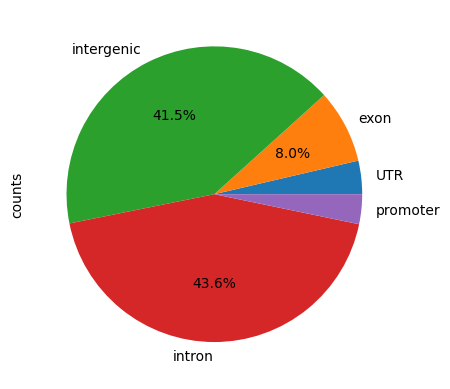

In [20]:
df_cCRE_primary_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

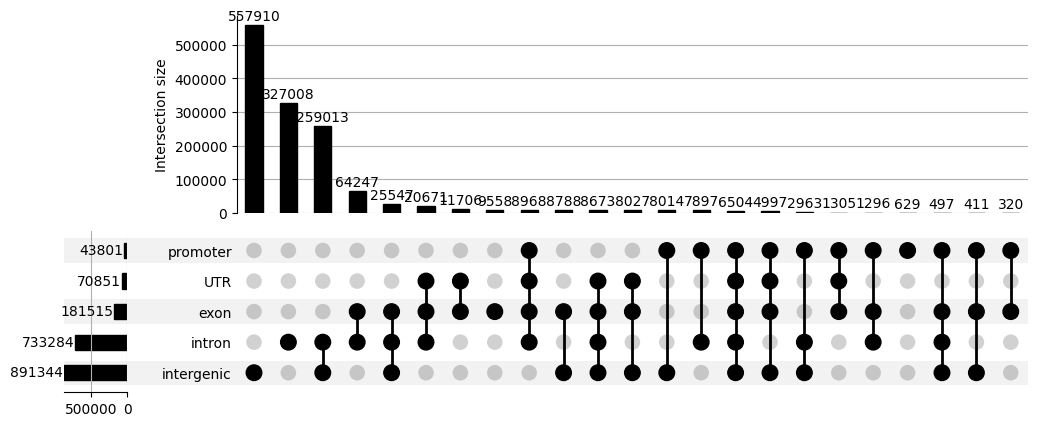

In [21]:
ax_dict = UpSet(cCRE_primary_gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [22]:
cCCRE_secondary_gene_regions = {
    # 'intron': set(dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name),
    # 'exon': set(dict_annot['exon_selected'].names+"_"+dict_annot['exon_selected'].gene_name),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    'LINE': set(dict_annot['LINE'].names),
    'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
cCCRE_secondary_gene_regions = from_contents(cCCRE_secondary_gene_regions)

In [23]:
second_priority = [
    "cpg",
    "LTR",
    "LINE",
    "SINE",
    "repeat"
]

/tmp/ipykernel_875149/2052237438.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'repeat' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_in.loc[df_in[column]==True,"annotation"] = column


<Axes: ylabel='counts'>

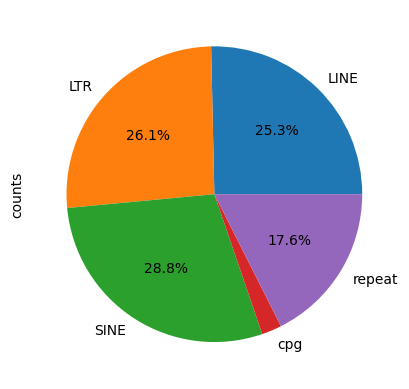

In [24]:
df_cCRE_secondary = cCCRE_secondary_gene_regions.reset_index()
df_cCRE_secondary = get_proity_region(df_cCRE_secondary,priority=second_priority)
df_cCRE_secondary_c = df_cCRE_secondary.groupby(['annotation']).size().reset_index(name='counts')
df_cCRE_secondary_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

/tmp/ipykernel_875149/2201135378.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


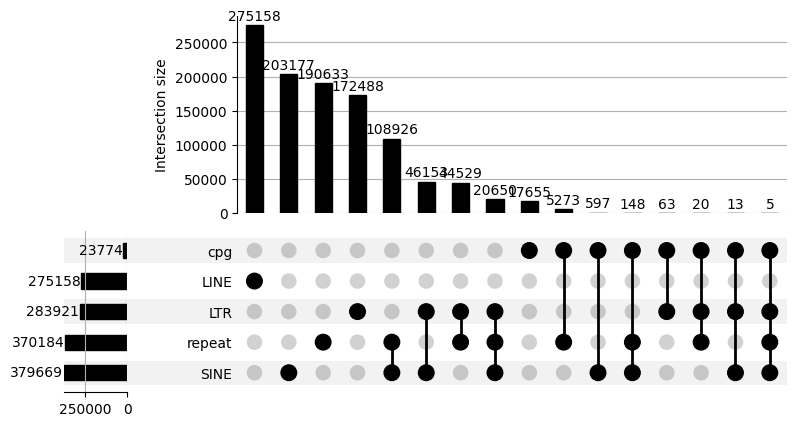

In [25]:
upset = UpSet(cCCRE_secondary_gene_regions, subset_size="count", sort_by="cardinality", show_counts=True)
ax_dict = upset.plot()
# for rect in ax_dict['intersections'].containers:
#     ax_dict['intersections'].bar_label(
#         rect,
#         rotation=45
#     )
# upset = UpSet(gene_regions, subset_size="count", sort_by="cardinality")
# ax_dict2 = upset.plot()

plt.tight_layout()
plt.show()
gene_regions_peaks = cCCRE_secondary_gene_regions

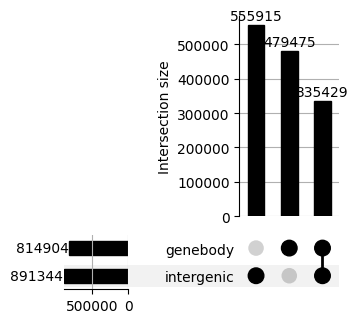

In [26]:
gene_regions = {
    'genebody': set(dict_annot['genebody'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


Calculate the peak proportion in each subtype

In [27]:
# If the peak macs ends
df_allpeaks = pd.read_csv("/data2st1/junyi/output/atac0416/iterative/peaks.csv",index_col=0)
df_allpeaks.set_index('Peaks', inplace=True)
df_nonoverlapping = pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed", sep="\t", header=None)    
df_nonoverlapping["names"] = df_nonoverlapping[0] + ":" + df_nonoverlapping[1].astype(str) + "-" + df_nonoverlapping[2].astype(str) 
df_overlapping = pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed", sep="\t", header=None)
df_overlapping["names"] = df_overlapping[0] + ":" + df_overlapping[1].astype(str) + "-" + df_overlapping[2].astype(str)
#df_overlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).difference(set(df_allpeaks.index.values)))]
df_unoverlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).intersection(set(df_allpeaks.index.values)))]
df_overlap = df_allpeaks.loc[list(set(df_overlapping.names.values).intersection(set(df_allpeaks.index.values)))]
df_unoverlap_count = df_unoverlap.sum(axis=1).reset_index()
df_overlap_count = df_overlap.sum(axis=1).reset_index()
df_overlap_count["count"] = df_overlap_count[0].clip(0,10)
df_unoverlap_count["count"] = df_unoverlap_count[0].clip(0,10)
cluster_counts = df_overlap_count.groupby("count").size().reset_index(name='counts').counts.values.tolist()
df_ovlap_c = df_overlap_count.groupby("count").size().reset_index(name='counts')
df_unoverlap_c = df_unoverlap_count.groupby("count").size().reset_index(name='counts')

<Axes: ylabel='counts'>

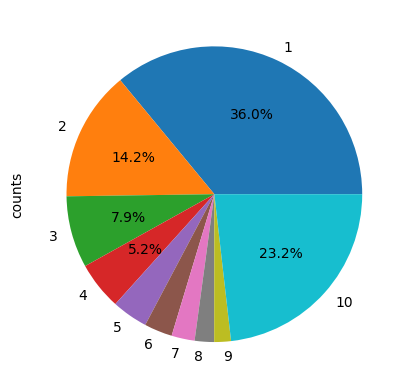

In [28]:
df_unoverlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


<Axes: ylabel='counts'>

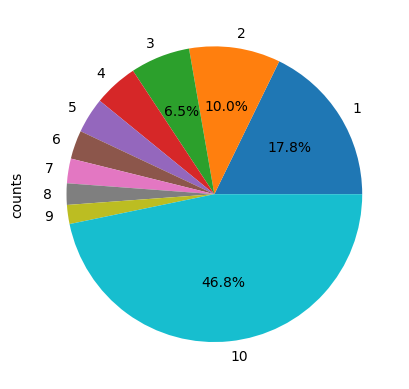

In [29]:
df_ovlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


DEG related statistics

In [5]:
df_deg = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_mememto.csv")
df_wicox = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")
df_memht = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_mementoht.csv")
df_deg.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed",index=False,header=False, sep="\t")
df_wicox.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed",index=False,header=False, sep="\t")
df_memht.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_memht.bed",index=False,header=False, sep="\t")

Calculated the overlap between dar and annotations

In [31]:
# annotations = [
#     "/data2st1/junyi/generegion_vM23/intron_selected.bed",
#     "/data2st1/junyi/generegion_vM23/exon_selected.bed",
#     "/data2st1/junyi/generegion_vM23/promoter2k.bed",
#     #"/data2st1/junyi/generegion_vM23/repeat.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
#     "/data2st1/junyi/generegion_vM23/UTR.bed",
#     "/data2st1/junyi/generegion_vM23/CDS.bed",
#     "/data2st1/junyi/generegion_vM23/genebody.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
# ]

dict_annot_deg = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot_deg[name] = df_annot
        print(f"Processed {file},{len(dict_annot_deg[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

# dict_annot_deg = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_deg[["names","ctname","condition"]],region_col='names', bedfile=file)
#         dict_annot_deg[name] = df_annot[df_annot.distance==0]
#         dict_annot_deg['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot_deg[name])}")
#     except Exception as e:
#         print(f"Error processing {file}, {e}")
        
#         continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,203276
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,162702
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,82062
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,5463
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,14913
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,6451
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,35159
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,33288


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,92889


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,52053


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,85759
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,59409


In [32]:
dict_annot_wil = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot_wil[name] = df_annot
        print(f"Processed {file},{len(dict_annot_wil[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,172723
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,100534
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,48476
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,7629
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,15928
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,8691
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,20446
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,26395


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,55191


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,33160


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,66769
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,51557


In [7]:
dict_annot_memht = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memht.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot_memht[name] = df_annot
        print(f"Processed {file},{len(dict_annot_memht[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,15040
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,29550
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,15906
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,129
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,486
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,129
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,6774
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,3123


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,18832


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,7221


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,10156
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,6147


Calcluated the overlap between dar and rdhs

In [33]:
inte_dar_me,non_overlapping_dar_mem = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", bed_rdhs)

In [34]:
n_ovlp_me = len(inte_dar_me.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar = len(df_deg)
non_ovlp_me = len(non_overlapping_dar_mem)

In [35]:
venn2(subsets=( n_dar-n_ovlp_me, n_rDHS-n_ovlp_me, n_ovlp_me), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of DAR and rDHS")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_rDHS.svg", dpi=300, bbox_inches='tight')
plt.close()

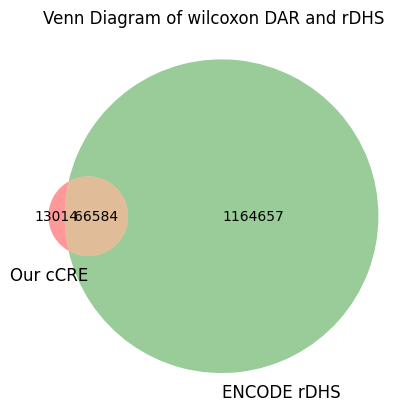

In [57]:
df_wil =pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", sep="\t", header=None)
inter_dar_wil ,non_overlapping_dar_wil = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", bed_rdhs)
n_ovlp_wil = len(inter_dar_wil.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar_wil = len(df_wil)
non_ovlp_wil = len(non_overlapping_dar_wil)
venn2(subsets=( n_dar_wil-n_ovlp_wil, n_rDHS-n_ovlp_wil, n_ovlp_wil), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of wilcoxon DAR and rDHS")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_wilcoxon_rDHS.svg", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

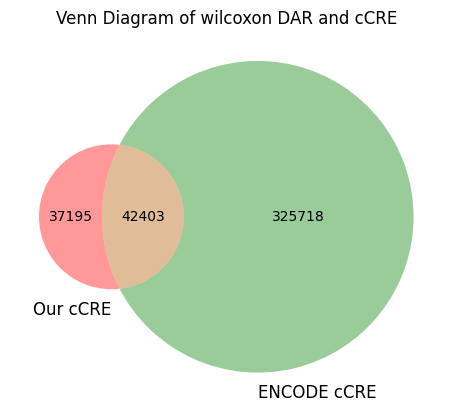

In [58]:
inter_dar_wil ,non_overlapping_dar_wil = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", bed_encode)
n_ovlp_wil = len(inter_dar_wil.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar_wil = len(df_wil)
non_ovlp_wil = len(non_overlapping_dar_wil)
venn2(subsets=( n_dar_wil-n_ovlp_wil, n_encodeCCRE-n_ovlp_wil, n_ovlp_wil), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of wilcoxon DAR and cCRE")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_wilcoxon_cCRE.svg", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


Calculated the overlap between our cCRE and ENCODE cCRE

In [36]:
inte_dar_me,non_overlapping_dar_mem = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", bed_encode)
n_ovlp_me = len(inte_dar_me.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar = len(df_deg)
non_ovlp_me = len(non_overlapping_dar_mem)

In [37]:
venn2(subsets=( n_dar-n_ovlp_me, n_encodeCCRE-n_ovlp_me, n_ovlp_me), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of DAR and cCRE")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_cCRE.svg", dpi=300, bbox_inches='tight')
plt.close()

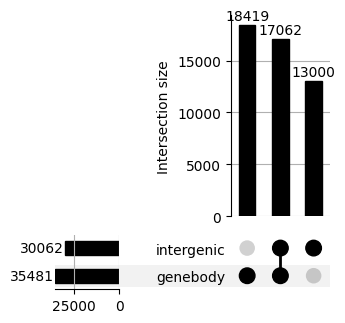

In [38]:
memento_gene_regions = {
    'genebody': set(dict_annot_deg['genebody'].names),
    'intergenic': set(dict_annot_deg['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
memento_gene_regions = from_contents(memento_gene_regions)
ax_dict = UpSet(memento_gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

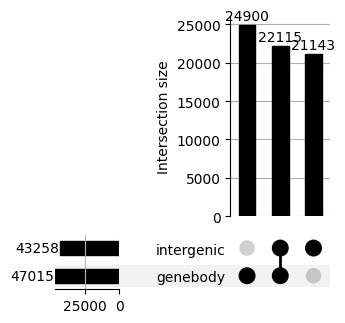

In [39]:
wilcox_gene_regions = {
    'genebody': set(dict_annot_wil['genebody'].names),
    'intergenic': set(dict_annot_wil['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
wilcox_gene_regions = from_contents(wilcox_gene_regions)
ax_dict = UpSet(wilcox_gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

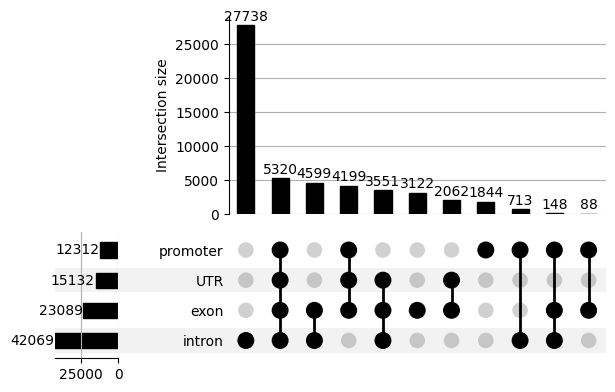

In [40]:
wilcox_primary_regions = {
    'intron': set(dict_annot_wil['intron_selected'].names+"_"+dict_annot_wil['intron_selected'].gene_name),
    'exon': set(dict_annot_wil['exon_selected'].names+"_"+dict_annot_wil['exon_selected'].gene_name),
    'promoter': set(dict_annot_wil['promoter2k'].names+"_"+dict_annot_wil['promoter2k'].gene_name),
    'UTR': set(dict_annot_wil['UTR'].names+"_"+dict_annot_wil['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
wilcox_primary_regions = from_contents(wilcox_primary_regions)
ax_dict = UpSet(wilcox_primary_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

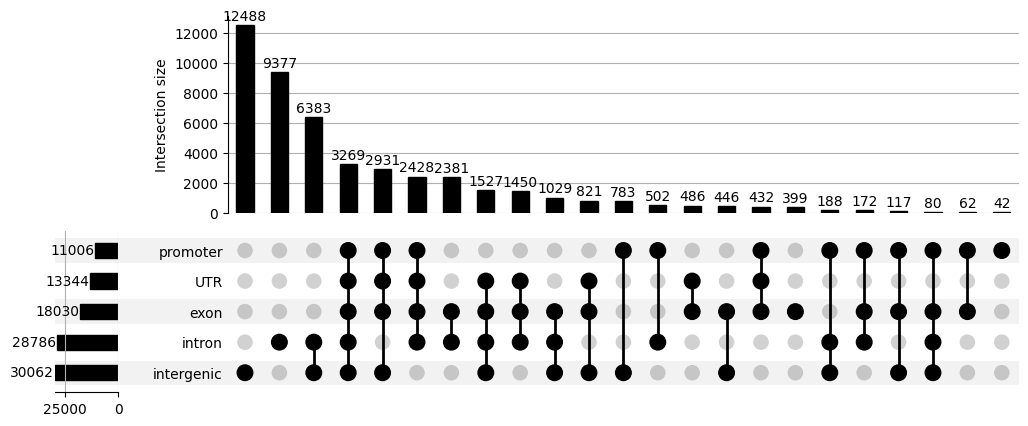

In [41]:
memento_primary_regions = {
    'intron': set(dict_annot_deg['intron_selected'].names),
    'exon': set(dict_annot_deg['exon_selected'].names),
    'promoter': set(dict_annot_deg['promoter2k'].names),
    'UTR': set(dict_annot_deg['UTR'].names),
    'intergenic': set(dict_annot_deg['intergenic'].names),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
memento_primary_regions = from_contents(memento_primary_regions)
ax_dict = UpSet(memento_primary_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

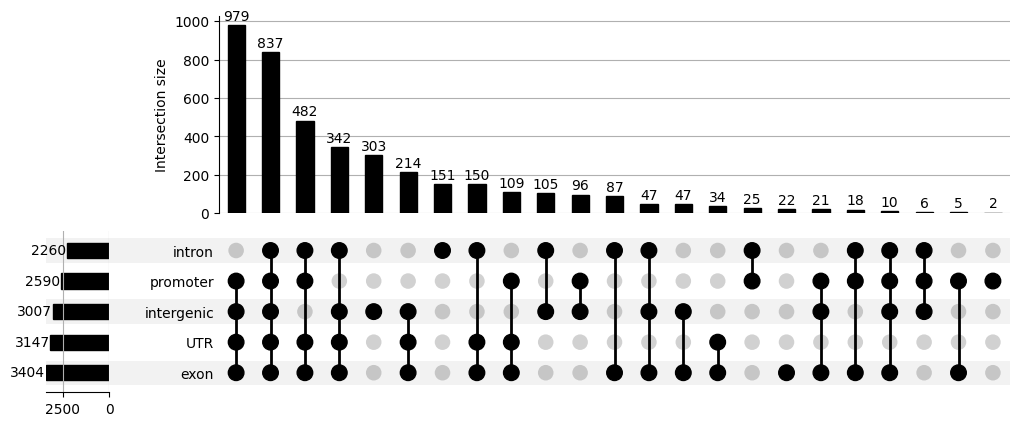

In [8]:
mento_ht_primary_regions = {
    'intron': set(dict_annot_memht['intron_selected'].names),
    'exon': set(dict_annot_memht['exon_selected'].names),
    'promoter': set(dict_annot_memht['promoter2k'].names),
    'UTR': set(dict_annot_memht['UTR'].names),
    'intergenic': set(dict_annot_memht['intergenic'].names),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
mento_ht_primary_regions = from_contents(mento_ht_primary_regions)
ax_dict = UpSet(mento_ht_primary_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

<Axes: ylabel='counts'>

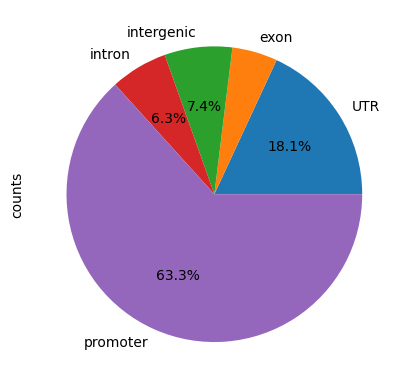

In [11]:
df_memntoht_primary = mento_ht_primary_regions.reset_index()
df_memntoht_primary = get_proity_region(df_memntoht_primary)
df_memntoht_primary_c = df_memntoht_primary.groupby(['annotation']).size().reset_index(name='counts')
df_memntoht_primary_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [17]:
df_memntoht_primary['names'] = df_memntoht_primary['id']

In [18]:
df_memntoht_primary

,promoter,UTR,exon,intron,intergenic,id,annotation,names
0,True,True,True,True,False,chr12:49383582-49384083,promoter,chr12:49383582-49384083
1,True,True,True,True,True,chr19:45047500-45048001,promoter,chr19:45047500-45048001
2,True,True,True,True,False,chr7:45784980-45785481,promoter,chr7:45784980-45785481
3,True,False,False,True,False,chr15:98808786-98809287,promoter,chr15:98808786-98809287
4,False,True,True,True,True,chr7:140082246-140082747,UTR,chr7:140082246-140082747
...,...,...,...,...,...,...,...,...
4087,False,False,False,False,True,chr2:122375375-122375876,intergenic,chr2:122375375-122375876
4088,False,False,False,False,True,chr14:52104033-52104534,intergenic,chr14:52104033-52104534
4089,False,False,False,False,True,chr15:38697358-38697859,intergenic,chr15:38697358-38697859
4090,False,False,False,False,True,chr2:152406026-152406527,intergenic,chr2:152406026-152406527


In [43]:
df_memento_primary_regions=memento_primary_regions.reset_index()
df_memento_primary_regions = get_proity_region(df_memento_primary_regions)

/tmp/ipykernel_875149/2052237438.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'intergenic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_in.loc[df_in[column]==True,"annotation"] = column


<Axes: ylabel='counts'>

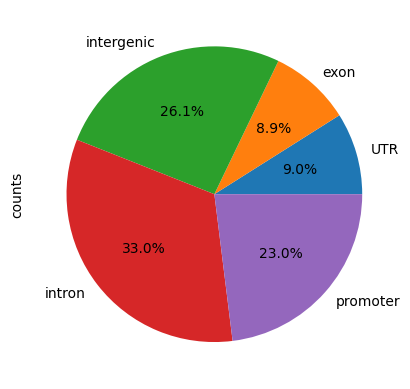

In [44]:
df_memento_primary_regions_c= df_memento_primary_regions.groupby("annotation").size().reset_index(name='counts')
df_memento_primary_regions_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [45]:
np.percentile(df_deg["distance"].values, 95)

11660.5

In [46]:
np.percentile(df_deg["distance"].values, 5)

-10518.0

array([[<Axes: title={'center': 'distance'}>]], dtype=object)

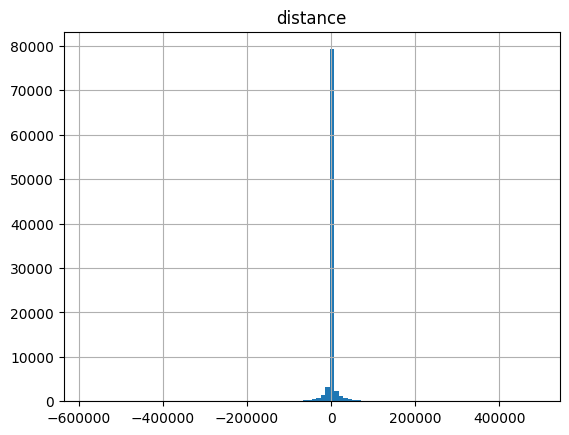

In [47]:
df_deg.hist(column="distance", bins=100)


(0.0, 1000.0)

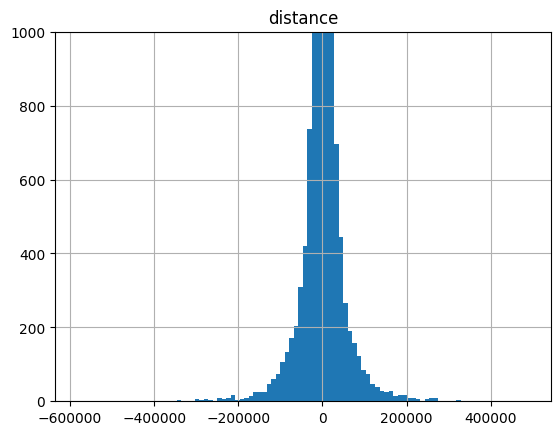

In [48]:
df_deg.hist(column="distance", bins=100)
plt.ylim(0, 1000)

Load intersection results from snRNA

In [52]:
df_deg_sc = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_degdar.csv")

In [50]:
df_memento_primary_regions['names'] = df_memento_primary_regions['id'].str.split("_").str[0]

In [51]:
df_memento_primary_regions.set_index('names', inplace=True)


In [54]:
df_sc_primary_regions = df_memento_primary_regions.loc[list(set(df_deg_sc.names.values).intersection(set(df_memento_primary_regions.index.values)))]

<Axes: ylabel='counts'>

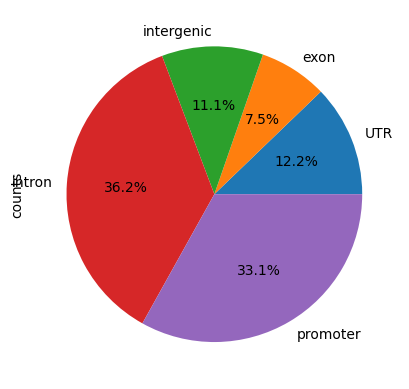

In [55]:
df_puei_sc_c=df_sc_primary_regions.groupby("annotation").size().reset_index(name='counts')
df_puei_sc_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [184]:
df_deg_merge = df_deg.merge(df_memento_primary_regions[['annotation']], on="names", how="left")
#df_deg_merge["annotation_y"] = df_deg_merge["annotation_y"].fillna("intergenic")
df_deg_sc_merge = df_deg_sc.merge(df_memento_primary_regions[['annotation']], on="names", how="left")
#df_deg_sc_merge["annotation"] = df_deg_sc_merge["annotation"].fillna("intergenic")

In [27]:
def is_promoter(row,interval_col="names"):
    """
    判断两个染色体区间是否有交集
    参数:
        row: DataFrame的一行数据，包含以下列:
            - interval: 格式如"chr1:2000-2100"
            - start2: 第二个区间的起始位置
            - end2: 第二个区间的结束位置
    返回:
        bool: 两个区间是否有交集
    """
    # 解析第一个区间
    chrom_part, pos_part = row[interval_col].split(':')
    start1, end1 = map(int, pos_part.split('-'))
    strand = row['strand']

    if strand == "+":
        # 如果是正链，start1和end1不变
        # 获取第二个区间
        start2 = row['gstart']-2000
        end2 = row['gstart']
    else:
        strand = "-"
        start2 = row['gend']
        end2 = row['gend']+2000
    # 判断是否有交集
    return not (end1 < start2 or end2 < start1)

In [ ]:
df_deg_merge.loc[((df_deg_merge.annotation_y.isna()) | (df_deg_merge.annotation_y=="intergenic")) & (df_deg_merge.apply(is_promoter, axis=1)),"annotation_y"] = "promoter"
df_deg_merge.loc[((df_deg_merge.annotation_y.isna()) | (df_deg_merge.annotation_y=="intergenic")) & (df_deg_merge.strand=="+") & (df_deg_merge.distance<0),"annotation_y"] = "downstream"
df_deg_merge.loc[((df_deg_merge.annotation_y.isna()) | (df_deg_merge.annotation_y=="intergenic")) & (df_deg_merge.strand=="-") & (df_deg_merge.distance>0),"annotation_y"] = "downstream"
df_deg_merge.loc[((df_deg_merge.annotation_y.isna()) | (df_deg_merge.annotation_y=="intergenic")) & (df_deg_merge.strand=="+") & (df_deg_merge.distance>2000),"annotation_y"] = "distal"
df_deg_merge.loc[((df_deg_merge.annotation_y.isna()) | (df_deg_merge.annotation_y=="intergenic")) & (df_deg_merge.strand=="-") & (df_deg_merge.distance<-2000),"annotation_y"] = "distal"
#assert df_deg_merge[df_deg_merge.annotation_y=="intergenic"].distance.values.min() == df_deg_merge[df_deg_merge.annotation_y=="intergenic"].distance.values.max() ==0
df_deg_merge.loc[(df_deg_merge.annotation_x=="genebody") & (df_deg_merge.distance==0) & ((df_deg_merge.annotation_y.isna()) | (df_deg_merge.annotation_y=="intergenic")),"annotation_y"] = "genebody"
df_deg_merge.rename(columns={"annotation_y":"primary_region"}, inplace=True)

<Axes: ylabel='counts'>

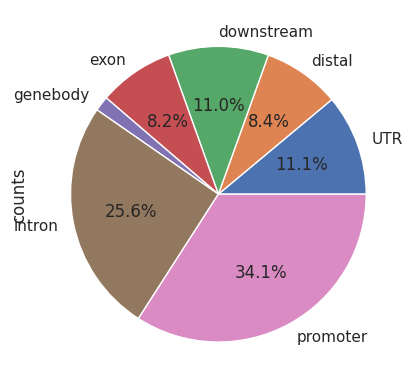

In [193]:
df_deg_region_c=df_deg_merge.groupby("primary_region").size().reset_index(name='counts')
df_deg_region_c.set_index('primary_region').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [13]:
df_memht

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance
0,chr15:75086569-75087070,stim,0.543514,0.025086,2.005070e-103,-0.324552,0.121464,5.376657e-03,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476
1,chr17:39845182-39845683,stim,0.305244,0.015771,2.393507e-83,-0.463456,0.084787,5.484868e-08,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0
2,chr17:39845723-39846224,stim,0.296083,0.015429,3.627698e-82,-0.440712,0.071073,1.178558e-09,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0
3,chr17:39844552-39845053,stim,0.256591,0.014457,1.316206e-70,-0.346129,0.068452,1.418557e-06,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0
4,chr17:39848454-39848955,stim,0.291267,0.017412,1.044956e-62,-0.399996,0.074567,7.602999e-08,PFC_Glut,PFC,MC,Gm42418,ENSMUSG00000098178.1,39846957,39848788,+,genebody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,chr16:87454730-87455231,stim,-0.077066,0.039153,4.909393e-02,0.263210,0.195031,2.219423e-01,AMY_GABA,AMY,MW,Usp16,ENSMUSG00000025616.14,87454702,87483517,+,genebody,0
8332,chr10:58446562-58447063,stim,-0.066754,0.034573,4.925000e-02,-0.318455,0.223360,9.352124e-02,AMY_GABA,AMY,MW,Ranbp2,ENSMUSG00000003226.7,58446919,58494356,+,genebody,0
8333,chr13:41015997-41016498,stim,-0.074610,0.038796,4.926897e-02,0.011347,0.187276,9.258334e-01,AMY_GABA,AMY,MW,Tmem14c,ENSMUSG00000021361.7,41016291,41022586,+,genebody,0
8334,chr8:105224882-105225383,stim,-0.085742,0.044847,4.930091e-02,-0.241672,0.230437,2.697857e-01,AMY_GABA,AMY,MW,D230025D16Rik,ENSMUSG00000031889.9,105225144,105253053,+,genebody,0


In [24]:
df_memht

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance
0,chr15:75086569-75087070,stim,0.543514,0.025086,2.005070e-103,-0.324552,0.121464,5.376657e-03,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476
1,chr17:39845182-39845683,stim,0.305244,0.015771,2.393507e-83,-0.463456,0.084787,5.484868e-08,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0
2,chr17:39845723-39846224,stim,0.296083,0.015429,3.627698e-82,-0.440712,0.071073,1.178558e-09,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0
3,chr17:39844552-39845053,stim,0.256591,0.014457,1.316206e-70,-0.346129,0.068452,1.418557e-06,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0
4,chr17:39848454-39848955,stim,0.291267,0.017412,1.044956e-62,-0.399996,0.074567,7.602999e-08,PFC_Glut,PFC,MC,Gm42418,ENSMUSG00000098178.1,39846957,39848788,+,genebody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,chr16:87454730-87455231,stim,-0.077066,0.039153,4.909393e-02,0.263210,0.195031,2.219423e-01,AMY_GABA,AMY,MW,Usp16,ENSMUSG00000025616.14,87454702,87483517,+,genebody,0
8332,chr10:58446562-58447063,stim,-0.066754,0.034573,4.925000e-02,-0.318455,0.223360,9.352124e-02,AMY_GABA,AMY,MW,Ranbp2,ENSMUSG00000003226.7,58446919,58494356,+,genebody,0
8333,chr13:41015997-41016498,stim,-0.074610,0.038796,4.926897e-02,0.011347,0.187276,9.258334e-01,AMY_GABA,AMY,MW,Tmem14c,ENSMUSG00000021361.7,41016291,41022586,+,genebody,0
8334,chr8:105224882-105225383,stim,-0.085742,0.044847,4.930091e-02,-0.241672,0.230437,2.697857e-01,AMY_GABA,AMY,MW,D230025D16Rik,ENSMUSG00000031889.9,105225144,105253053,+,genebody,0


In [26]:
df_memht_merge = df_memht.merge(df_memntoht_primary[['annotation',"names"]], on="names", how="left")
df_memht_merge


,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation_x,distance,annotation_y
0,chr15:75086569-75087070,stim,0.543514,0.025086,2.005070e-103,-0.324552,0.121464,5.376657e-03,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,intergenic
1,chr17:39845182-39845683,stim,0.305244,0.015771,2.393507e-83,-0.463456,0.084787,5.484868e-08,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon
2,chr17:39845723-39846224,stim,0.296083,0.015429,3.627698e-82,-0.440712,0.071073,1.178558e-09,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon
3,chr17:39844552-39845053,stim,0.256591,0.014457,1.316206e-70,-0.346129,0.068452,1.418557e-06,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon
4,chr17:39848454-39848955,stim,0.291267,0.017412,1.044956e-62,-0.399996,0.074567,7.602999e-08,PFC_Glut,PFC,MC,Gm42418,ENSMUSG00000098178.1,39846957,39848788,+,genebody,0,exon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,chr16:87454730-87455231,stim,-0.077066,0.039153,4.909393e-02,0.263210,0.195031,2.219423e-01,AMY_GABA,AMY,MW,Usp16,ENSMUSG00000025616.14,87454702,87483517,+,genebody,0,UTR
8332,chr10:58446562-58447063,stim,-0.066754,0.034573,4.925000e-02,-0.318455,0.223360,9.352124e-02,AMY_GABA,AMY,MW,Ranbp2,ENSMUSG00000003226.7,58446919,58494356,+,genebody,0,promoter
8333,chr13:41015997-41016498,stim,-0.074610,0.038796,4.926897e-02,0.011347,0.187276,9.258334e-01,AMY_GABA,AMY,MW,Tmem14c,ENSMUSG00000021361.7,41016291,41022586,+,genebody,0,promoter
8334,chr8:105224882-105225383,stim,-0.085742,0.044847,4.930091e-02,-0.241672,0.230437,2.697857e-01,AMY_GABA,AMY,MW,D230025D16Rik,ENSMUSG00000031889.9,105225144,105253053,+,genebody,0,promoter


In [28]:
df_memht_merge.loc[((df_memht_merge.annotation_y.isna()) | (df_memht_merge.annotation_y=="intergenic")) & (df_memht_merge.apply(is_promoter, axis=1)),"annotation_y"] = "promoter"
df_memht_merge.loc[((df_memht_merge.annotation_y.isna()) | (df_memht_merge.annotation_y=="intergenic")) & (df_memht_merge.strand=="+") & (df_memht_merge.distance<0),"annotation_y"] = "downstream"
df_memht_merge.loc[((df_memht_merge.annotation_y.isna()) | (df_memht_merge.annotation_y=="intergenic")) & (df_memht_merge.strand=="-") & (df_memht_merge.distance>0),"annotation_y"] = "downstream"
df_memht_merge.loc[((df_memht_merge.annotation_y.isna()) | (df_memht_merge.annotation_y=="intergenic")) & (df_memht_merge.strand=="+") & (df_memht_merge.distance>2000),"annotation_y"] = "distal"
df_memht_merge.loc[((df_memht_merge.annotation_y.isna()) | (df_memht_merge.annotation_y=="intergenic")) & (df_memht_merge.strand=="-") & (df_memht_merge.distance<-2000),"annotation_y"] = "distal"
#assert df_memht_merge[df_memht_merge.annotation_y=="intergenic"].distance.values.min() == df_memht_merge[df_memht_merge.annotation_y=="intergenic"].distance.values.max() ==0
df_memht_merge.loc[(df_memht_merge.annotation_x=="genebody") & (df_memht_merge.distance==0) & ((df_memht_merge.annotation_y.isna()) | (df_memht_merge.annotation_y=="intergenic")),"annotation_y"] = "genebody"
df_memht_merge.rename(columns={"annotation_y":"primary_region"}, inplace=True)

In [29]:
df_memht_merge

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation_x,distance,primary_region
0,chr15:75086569-75087070,stim,0.543514,0.025086,2.005070e-103,-0.324552,0.121464,5.376657e-03,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,distal
1,chr17:39845182-39845683,stim,0.305244,0.015771,2.393507e-83,-0.463456,0.084787,5.484868e-08,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon
2,chr17:39845723-39846224,stim,0.296083,0.015429,3.627698e-82,-0.440712,0.071073,1.178558e-09,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon
3,chr17:39844552-39845053,stim,0.256591,0.014457,1.316206e-70,-0.346129,0.068452,1.418557e-06,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon
4,chr17:39848454-39848955,stim,0.291267,0.017412,1.044956e-62,-0.399996,0.074567,7.602999e-08,PFC_Glut,PFC,MC,Gm42418,ENSMUSG00000098178.1,39846957,39848788,+,genebody,0,exon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,chr16:87454730-87455231,stim,-0.077066,0.039153,4.909393e-02,0.263210,0.195031,2.219423e-01,AMY_GABA,AMY,MW,Usp16,ENSMUSG00000025616.14,87454702,87483517,+,genebody,0,UTR
8332,chr10:58446562-58447063,stim,-0.066754,0.034573,4.925000e-02,-0.318455,0.223360,9.352124e-02,AMY_GABA,AMY,MW,Ranbp2,ENSMUSG00000003226.7,58446919,58494356,+,genebody,0,promoter
8333,chr13:41015997-41016498,stim,-0.074610,0.038796,4.926897e-02,0.011347,0.187276,9.258334e-01,AMY_GABA,AMY,MW,Tmem14c,ENSMUSG00000021361.7,41016291,41022586,+,genebody,0,promoter
8334,chr8:105224882-105225383,stim,-0.085742,0.044847,4.930091e-02,-0.241672,0.230437,2.697857e-01,AMY_GABA,AMY,MW,D230025D16Rik,ENSMUSG00000031889.9,105225144,105253053,+,genebody,0,promoter



 ​Priority Ranking (Highest to Lowest)​​
- ​CpG Islands​
    - Strongly associated with ​gene promoters​ and regulatory regions.
    - Key for ​DNA methylation​ and gene silencing (e.g., tumor suppressor genes).
    - ​Priority rationale:​​ Disruption can directly affect gene expression.
- ​LTR (Long Terminal Repeat) Elements​
    - Often contain ​functional promoters/enhancers​ (e.g., endogenous retroviruses).
    - Can regulate nearby genes (e.g., HERV-H in pluripotency).
    - ​Priority rationale:​​ Regulatory influence comparable to CpG islands.
- ​LINE (Long Interspersed Nuclear Elements)​​
    - Can harbor ​weak promoters​ and affect chromatin structure.
    - Less conserved than LTRs but still functional (e.g., LINE-1 ORF2 encodes reverse transcriptase).
    - ​Priority rationale:​​ Moderate regulatory potential.
- ​SINE (Short Interspersed Nuclear Elements)​​
    - Mostly ​non-autonomous, rely on LINE machinery.
    - Few known regulatory roles (exception: Alu elements in RNA editing).
    - ​Priority rationale:​​ Lowest functional impact unless in a transcribed region.


In [ ]:
def plot_stack_prop(df,x=None, y='proportion',pro_col='celltype.L1',color_palette=sns.color_palette("Set2"), figsize=(10, 6),x_order=None, **kwargs):
    counts = df.groupby([x, pro_col]).size().unstack(fill_value=0)
    # If x_order is provided, sort the index of counts
    if x_order is not None:
        counts = counts.loc[x_order]
    df_prop = counts.div(counts.sum(axis=1), axis=0) * 100
    df_prop = df_prop.reset_index().melt(id_vars=x, var_name=pro_col, value_name=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")
    # Initialize bottom positions for stacking
        # Sort the dataframe by the specified order by the column of sample name
    bottom = pd.Series([0] * len(df_prop[x].unique()), index=df_prop[x].unique())
    # Plot each celltype layer
    for i, celltype in enumerate(df_prop[pro_col].unique()):
        subset = df_prop[df_prop[pro_col] == celltype]
        sns.barplot(
            x=x, y=y, data=subset,
            label=celltype, bottom=bottom[subset[x]],
            color=color_palette[i]
        )
        bottom += subset.set_index(x)[y].reindex(bottom.index, fill_value=0)
    ax.set_title('Celltype Proportions per Sample')
    ax.set_ylabel('Proportion (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
    return fig,ax

#order = meta_atac.sort_values('Region')['sample'].unique()
df_deg_sc_merge['ctname_con'] = df_deg_sc_merge['ctname'].astype(str) + "_" + df_deg_sc_merge['condition'].astype(str)
plot_stack_prop(df_deg_sc_merge,x='ctname_con', y='proportion',pro_col="annotation",x_order=None, figsize=(10, 6))

NameError: name 'df_deg_sc_merge' is not defined

In [35]:
df_memht_merge

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation_x,distance,primary_region,ctname_con
0,chr15:75086569-75087070,stim,0.543514,0.025086,2.005070e-103,-0.324552,0.121464,5.376657e-03,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,distal,PFC_Glut_MC
1,chr17:39845182-39845683,stim,0.305244,0.015771,2.393507e-83,-0.463456,0.084787,5.484868e-08,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon,PFC_Glut_MC
2,chr17:39845723-39846224,stim,0.296083,0.015429,3.627698e-82,-0.440712,0.071073,1.178558e-09,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon,PFC_Glut_MC
3,chr17:39844552-39845053,stim,0.256591,0.014457,1.316206e-70,-0.346129,0.068452,1.418557e-06,PFC_Glut,PFC,MC,Gm26917,ENSMUSG00000097971.3,39843012,39846341,+,genebody,0,exon,PFC_Glut_MC
4,chr17:39848454-39848955,stim,0.291267,0.017412,1.044956e-62,-0.399996,0.074567,7.602999e-08,PFC_Glut,PFC,MC,Gm42418,ENSMUSG00000098178.1,39846957,39848788,+,genebody,0,exon,PFC_Glut_MC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,chr16:87454730-87455231,stim,-0.077066,0.039153,4.909393e-02,0.263210,0.195031,2.219423e-01,AMY_GABA,AMY,MW,Usp16,ENSMUSG00000025616.14,87454702,87483517,+,genebody,0,UTR,AMY_GABA_MW
8332,chr10:58446562-58447063,stim,-0.066754,0.034573,4.925000e-02,-0.318455,0.223360,9.352124e-02,AMY_GABA,AMY,MW,Ranbp2,ENSMUSG00000003226.7,58446919,58494356,+,genebody,0,promoter,AMY_GABA_MW
8333,chr13:41015997-41016498,stim,-0.074610,0.038796,4.926897e-02,0.011347,0.187276,9.258334e-01,AMY_GABA,AMY,MW,Tmem14c,ENSMUSG00000021361.7,41016291,41022586,+,genebody,0,promoter,AMY_GABA_MW
8334,chr8:105224882-105225383,stim,-0.085742,0.044847,4.930091e-02,-0.241672,0.230437,2.697857e-01,AMY_GABA,AMY,MW,D230025D16Rik,ENSMUSG00000031889.9,105225144,105253053,+,genebody,0,promoter,AMY_GABA_MW


/tmp/ipykernel_2212652/1462013514.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname_con', ylabel='Proportion (%)'>)

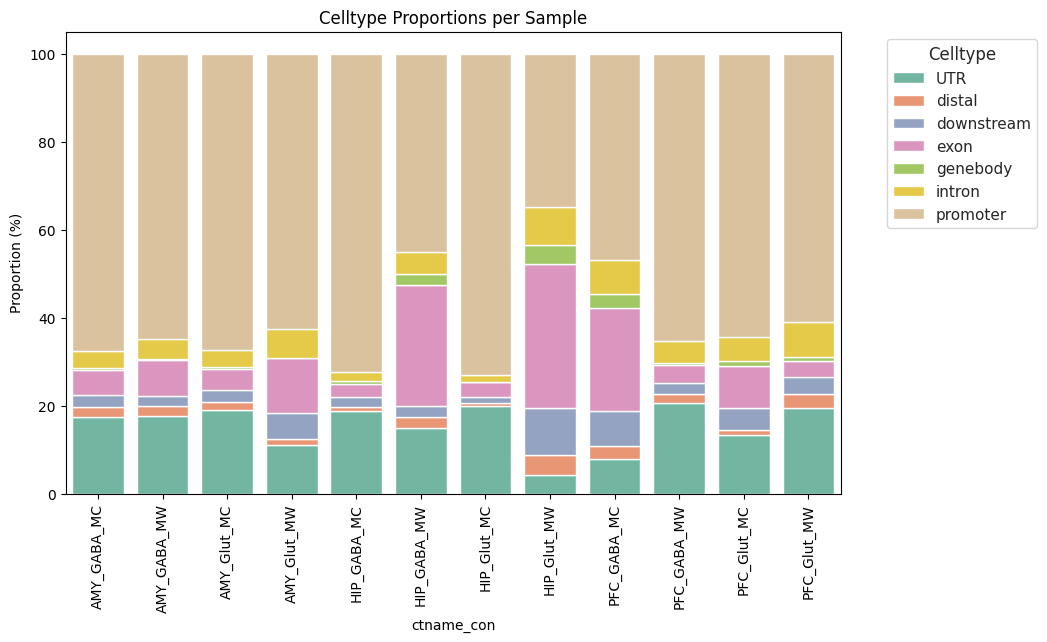

In [36]:
df_memht_merge['ctname_con'] = df_memht_merge['ctname'].astype(str) + "_" + df_memht_merge['condition'].astype(str)
plot_stack_prop(df_memht_merge,x='ctname_con', y='proportion',pro_col="primary_region",x_order=None, figsize=(10, 6))

/tmp/ipykernel_875149/2674298623.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname_con', ylabel='Proportion (%)'>)

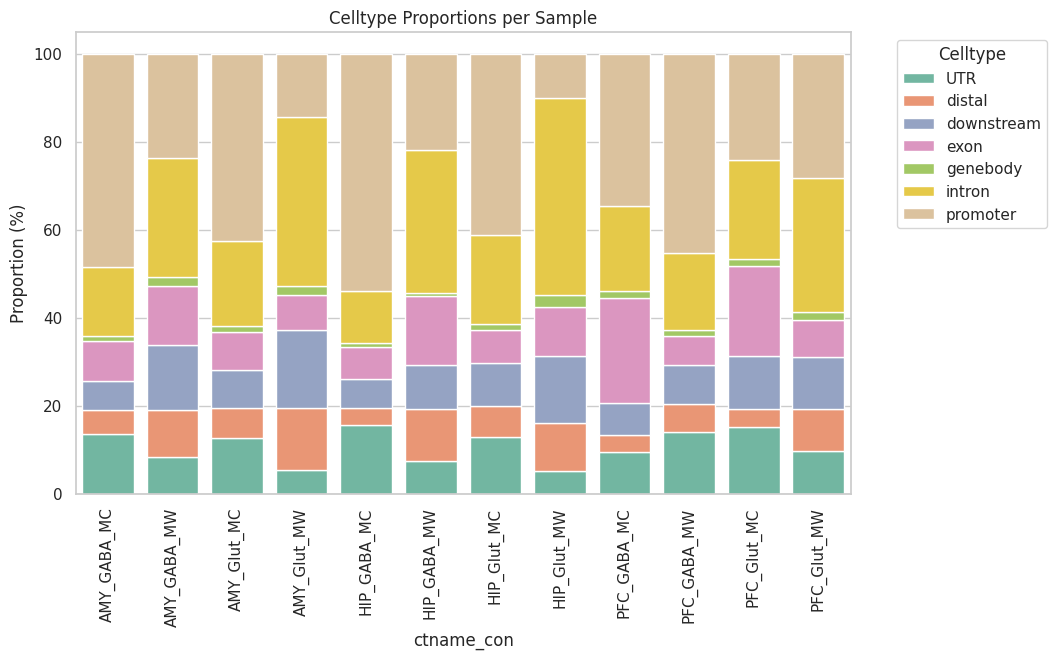

In [195]:
df_deg_merge['ctname_con'] = df_deg_merge['ctname'].astype(str) + "_" + df_deg_merge['condition'].astype(str)
plot_stack_prop(df_deg_merge,x='ctname_con', y='proportion',pro_col="primary_region",x_order=None, figsize=(10, 6))

In [298]:
# for ct in df_deg_merge.ctname.unique():
#     for con in df_deg_merge.condition.unique():
#         df_temp = df_deg_merge[(df_deg_merge.ctname==ct) & (df_deg_merge.condition==con)]
#         df_tem_group = df_temp.groupby("annotation_y").size().reset_index(name='counts')
        
#         df_tem_group.set_index('annotation_y').plot.pie(
#             y='counts',
#             autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
#             legend=False,
#             title=f"{ct}_{con} annotation" + f"({df_tem_group['counts'].sum()})",
#         )
        

In [299]:
# for ct in df_deg_sc_merge.ctname.unique():
#     for con in df_deg_sc_merge.condition.unique():
#         df_temp = df_deg_sc_merge[(df_deg_sc_merge.ctname==ct) & (df_deg_sc_merge.condition==con)]
#         df_tem_group = df_temp.groupby("annotation").size().reset_index(name='counts')
        
#         df_tem_group.set_index('annotation').plot.pie(
#             y='counts',
#             autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
#             legend=False,
#             title=f"{ct}_{con} annotation" + f"({df_tem_group['counts'].sum()})",
#         )

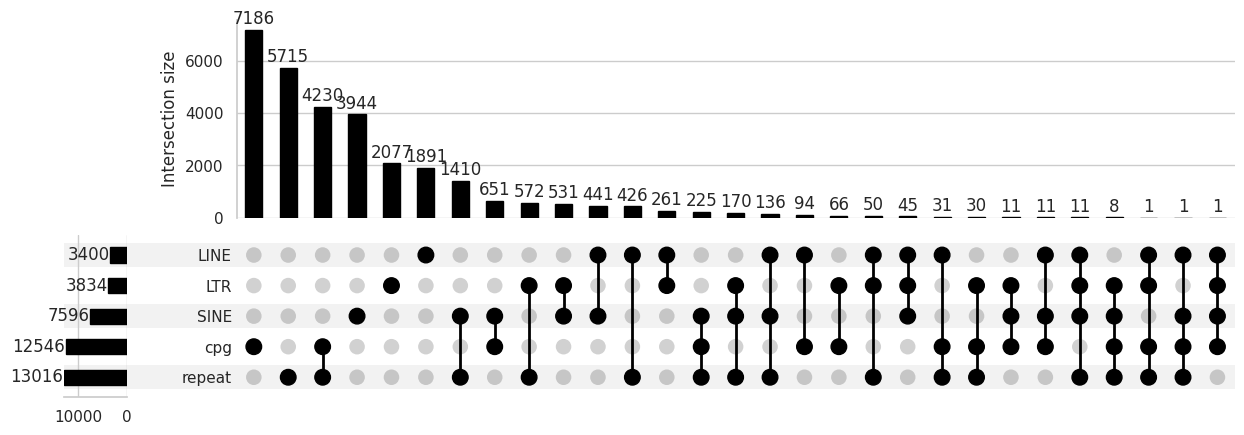

In [135]:
memento_secondary_regions = {
    'LINE': set(dict_annot_deg['LINE'].names),
    'SINE': set(dict_annot_deg['SINE'].names),
    'LTR': set(dict_annot_deg['LTR'].names),
    'repeat': set(dict_annot_deg['Other_repeats'].names),
    'cpg': set(dict_annot_deg['cpg'].names)
}
memento_secondary_regions = from_contents(memento_secondary_regions)
ax_dict = UpSet(memento_secondary_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [196]:
df_memnto_secondary_regions = memento_secondary_regions.reset_index()

In [37]:
second_priority =[
    "cpg",
    "LTR",
    "LINE",
    "SINE",
    "repeat"
]

In [198]:
df_memnto_secondary_regions = get_proity_region(df_memnto_secondary_regions,priority=second_priority)

/tmp/ipykernel_875149/2052237438.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'repeat' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_in.loc[df_in[column]==True,"annotation"] = column


In [199]:
df_memnto_secondary_regions.rename(columns={"id":"names","annotation":"secondary_region"}, inplace=True)

In [200]:
df_memnto_secondary_regions

,cpg,LTR,LINE,SINE,repeat,names,secondary_region
0,False,False,True,True,False,chr16:31903189-31903690,LINE
1,False,False,True,False,False,chr12:72178252-72178753,LINE
2,False,False,True,False,False,chr2:22864583-22865084,LINE
3,False,False,True,False,False,chr2:33033207-33033708,LINE
4,False,False,True,True,True,chr7:123035273-123035774,LINE
...,...,...,...,...,...,...,...
30221,True,False,False,False,False,chr13:36578455-36578956,cpg
30222,True,False,False,False,False,chr12:106009953-106010454,cpg
30223,True,False,False,False,False,chr2:140066554-140067055,cpg
30224,True,False,False,False,False,chr5:36988807-36989308,cpg


In [201]:
df_deg_merge = df_deg_merge.merge(df_memnto_secondary_regions[["names",'secondary_region']], on="names", how="left")

In [202]:
df_deg_merge.to_csv("/data2st1/junyi/output/atac0416/cCRE/df_deg_mento_annotated.csv",index=False)

/tmp/ipykernel_875149/2674298623.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='condition', ylabel='Proportion (%)'>)

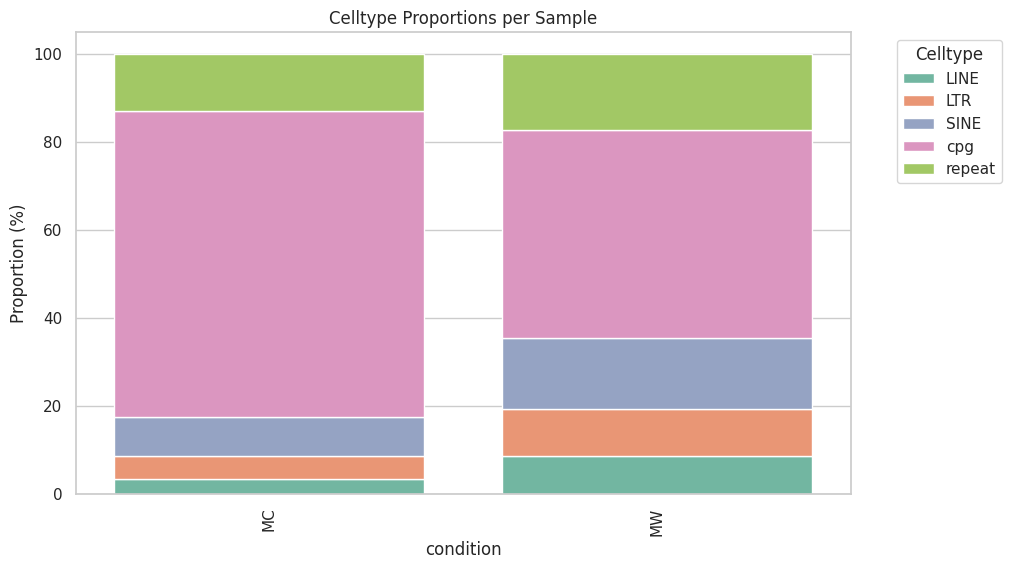

In [203]:
plot_stack_prop(df_deg_merge,x='condition', y='proportion',pro_col="secondary_region",x_order=None, figsize=(10, 6))# df_dmr

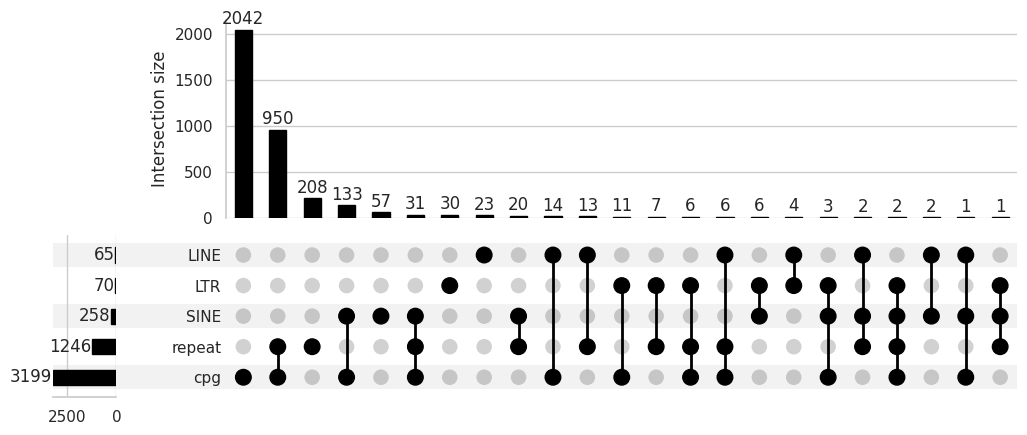

In [38]:
memht_secondary_regions = {
    'LINE': set(dict_annot_memht['LINE'].names),
    'SINE': set(dict_annot_memht['SINE'].names),
    'LTR': set(dict_annot_memht['LTR'].names),
    'repeat': set(dict_annot_memht['Other_repeats'].names),
    'cpg': set(dict_annot_memht['cpg'].names)
}
memht_secondary_regions = from_contents(memht_secondary_regions)
ax_dict = UpSet(memht_secondary_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

In [39]:
df_memht_secondary_regions = memht_secondary_regions.reset_index()
df_memht_secondary_regions = get_proity_region(df_memht_secondary_regions,priority=second_priority)
df_memht_secondary_regions.rename(columns={"id":"names","annotation":"secondary_region"}, inplace=True)

In [44]:
df_memht_merge = df_memht_merge.merge(df_memht_secondary_regions[["names",'secondary_region']], on="names", how="left")
df_memht_merge.to_csv("/data2st1/junyi/output/atac0416/cCRE/df_memht_mento_annotated.csv",index=False)

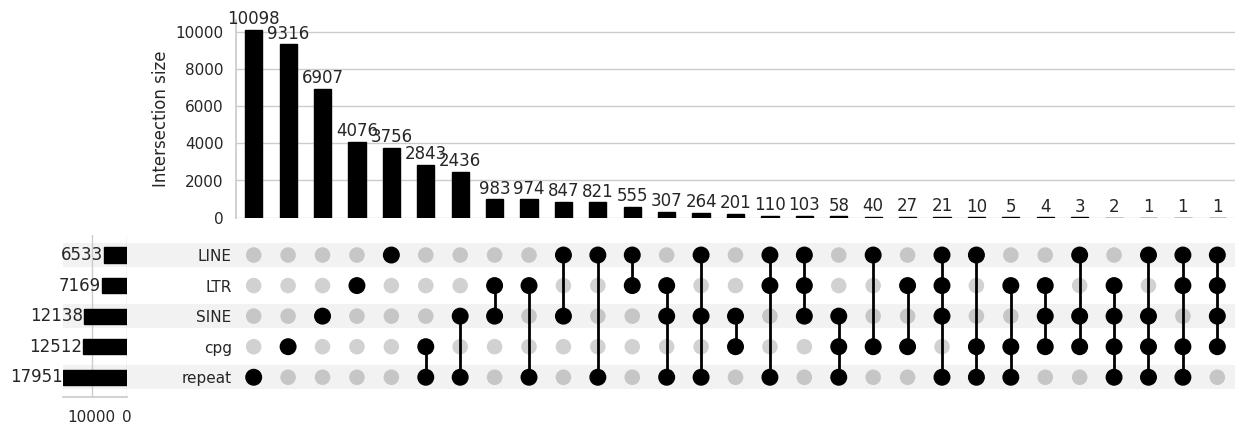

In [306]:
gene_regions = {
    'LINE': set(dict_annot_wil['LINE'].names+"_"+dict_annot_wil['LINE'].gene_name),
    'SINE': set(dict_annot_wil['SINE'].names+"_"+dict_annot_wil['SINE'].gene_name),
    'LTR': set(dict_annot_wil['LTR'].names+"_"+dict_annot_wil['LTR'].gene_name),
    'repeat': set(dict_annot_wil['Other_repeats'].names+"_"+dict_annot_wil['Other_repeats'].gene_name),
    'cpg': set(dict_annot_wil['cpg'].names+"_"+dict_annot_wil['cpg'].gene_name)
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()
    

In [307]:
df_dar_region_count = gene_regions.reset_index()
df_dar_region_count['count'] = df_dar_region_count.iloc[:,:-1].sum(axis=1)

In [308]:
df_dar_region_count.sort_values(by='count', ascending=False, inplace=True)

In [309]:
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
def geom_dar(T,n,dict_annot,dict_annot_deg):
    # T = len(df_allpeaks)
    # n = len(df_)
    # n = len(df_)
    list_name = []
    list_p = []
    list_odd = []
    list_fold = []
    list_pctb = []
    list_pctdar = []
    for key in dict_annot.keys():
        M = len(dict_annot[key].drop_duplicates(subset=["chrom","start","end"]))
        m = len(dict_annot_deg[key].drop_duplicates(subset=["chrom","start","end"]))
        p_value = hypergeom.sf(m-1, T, M, n)  # 右尾检验
        Oddr = (m / (n - m)) / ((M - m) / (T - M - n + m))
        fold_enrichment = (m / n) / (M / T)
        pct_background = M / T
        pct_dar = m / n

        # print(T, M,n, m)

        # contingency_table = [[m, M - m], [n - m, T - M - n + m]]
        # Oddr, p_value_fisher = fisher_exact(contingency_table, alternative='greater')


        list_name.append(key)
        list_p.append(p_value)
        list_odd.append(Oddr)
        list_fold.append(fold_enrichment)
        list_pctb.append(pct_background)
        list_pctdar.append(pct_dar)

    df_geom = pd.DataFrame({
        'name': list_name,
        'p_value': list_p,
        'Oddr': list_odd,
        'fold_enrichment': list_fold,
        'pct_background': list_pctb,
        'pct_dar': list_pctdar
    })
    df_geom['significant'] = df_geom['p_value'].apply(lambda x: 'yes' if x < 0.05 else 'no')
    
    return df_geom
# T = len(df_allpeaks)
# n = len(df_deg)
# # n = len(df_)
# list_name = []
# list_p = []
# list_odd = []
# list_fold = []
# list_pctb = []
# list_pctdar = []
# for key in dict_annot.keys():
#     M = len(dict_annot[key].drop_duplicates(subset=["chrom","start","end"]))
#     m = len(dict_annot_deg[key].drop_duplicates(subset=["chrom","start","end"]))
#     p_value = hypergeom.sf(m-1, T, M, n)  # 右尾检验
#     Oddr = (m / (n - m)) / ((M - m) / (T - M - n + m))
#     fold_enrichment = (m / n) / (M / T)
#     pct_background = M / T
#     pct_dar = m / n

#     # print(T, M,n, m)

#     # contingency_table = [[m, M - m], [n - m, T - M - n + m]]
#     # Oddr, p_value_fisher = fisher_exact(contingency_table, alternative='greater')


#     print(f"{key}: {p_value}, {Oddr}, {fold_enrichment}")
#     list_name.append(key)
#     list_p.append(p_value)
#     list_odd.append(Oddr)
#     list_fold.append(fold_enrichment)
#     list_pctb.append(pct_background)
#     list_pctdar.append(pct_dar)


In [310]:
df_deg[["names","ctname","condition","region"]]

,names,ctname,condition,region
0,chr15:75086569-75087070,PFC_Glut,MC,PFC
1,chr12:120028551-120029052,PFC_Glut,MC,PFC
2,chrX:143482812-143483313,PFC_Glut,MC,PFC
3,chr2:98662045-98662546,PFC_Glut,MC,PFC
4,chr2:98662628-98663129,PFC_Glut,MC,PFC
...,...,...,...,...
92126,chr8:110465569-110466070,AMY_GABA,MW,AMY
92127,chr2:29669624-29670125,AMY_GABA,MW,AMY
92128,chr16:94919198-94919699,AMY_GABA,MW,AMY
92129,chr8:105304519-105305020,AMY_GABA,MW,AMY


In [311]:
def gen_dict_with_query(dict_annot, qstring,df_deg):
    dict_merge = {}
    #subset_col = 'region'
    #qstring = 'condition.str.contains("MC")'
    for key in dict_annot.keys():
        df_merge = dict_annot_deg[key].merge(df_deg[["names","ctname","condition","region"]], on="names", how="left")
        result = df_merge.query(qstring)
        dict_merge[key] = result
    return dict_merge

In [312]:
df_deg.drop_duplicates(subset=["names"])

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance,de_pval_adj
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,9.510063e-86
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,Tmem196,ENSMUSG00000048004.15,119945821,120021246,+,genebody,-7306,3.234648e-81
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,4.431668e-61
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,6.164123e-57
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,7.114042e-43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92123,chr11:60176417-60176918,stim,-0.088886,0.045841,4.912257e-02,-0.419944,0.150944,5.957374e-03,AMY_GABA,AMY,MW,Rai1,ENSMUSG00000062115.15,60105012,60199197,+,genebody,0,4.928932e-02
92124,chr2:158743696-158744197,stim,-0.142601,0.073285,4.912315e-02,0.005755,0.198035,9.877142e-01,AMY_GABA,AMY,MW,Ppp1r16b,ENSMUSG00000037754.13,158665397,158766334,+,genebody,0,4.928932e-02
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,Hydin,ENSMUSG00000059854.8,110266976,110610253,+,genebody,0,4.945411e-02
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,Rapgef1,ENSMUSG00000039844.20,29619719,29740978,+,genebody,0,4.947963e-02


In [313]:
df_wil

,0,1,2
0,chr2,98666917,98667418
1,chr2,98662045,98662546
2,chr2,98666414,98666915
3,chr9,35305176,35305677
4,chr2,98662628,98663129
...,...,...,...
79593,chr2,149768495,149768996
79594,chr12,41674762,41675263
79595,chr2,28068461,28068962
79596,chr5,71011211,71011712


In [314]:
T = len(df_allpeaks)
n = len(df_deg.drop_duplicates(subset=["names"]))
df_geom_mem = geom_dar(T,n,dict_annot,dict_annot_deg)
n2 = len(df_wil.drop_duplicates())
df_geom_wil = geom_dar(T,n2,dict_annot,dict_annot_wil)

<Axes: xlabel='fold_enrichment', ylabel='name'>

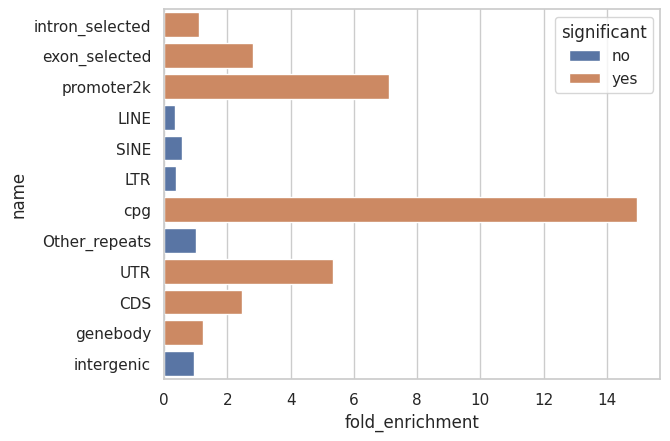

In [315]:
sns.barplot(data=df_geom_mem, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

<Axes: xlabel='fold_enrichment', ylabel='name'>

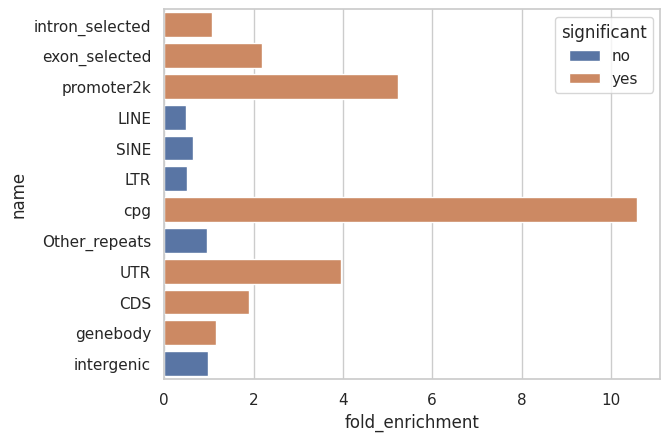

In [316]:
sns.barplot(data=df_geom_wil, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

In [317]:
qstring = 'condition.str.contains("MC") and ctname.str.contains("PFC_GABA")'
dic_merge_mem = gen_dict_with_query(dict_annot, qstring,df_deg)
len_mc = len(df_deg.query(qstring).names.unique())
df_geom_memMC = geom_dar(T,len_mc,dict_annot,dic_merge_mem)
df_geom_memMC
#sns.barplot(data=df_geom_memMC, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

,name,p_value,Oddr,fold_enrichment,pct_background,pct_dar,significant
0,intron_selected,4.462339e-11,2.189199,1.338039,0.534853,0.715655,yes
1,exon_selected,1.945113e-88,10.549715,4.657340,0.132396,0.616613,yes
2,promoter2k,1.078064e-77,15.774783,10.700224,0.031948,0.341853,yes
3,LINE,1.000000e+00,0.172540,0.206945,0.200699,0.041534,no
4,SINE,1.000000e+00,0.320698,0.394543,0.275322,0.108626,no
5,LTR,1.000000e+00,0.248397,0.294069,0.206424,0.060703,no
6,cpg,2.155822e-163,48.640371,26.566743,0.017317,0.460064,yes
7,Other_repeats,1.172305e-06,1.762806,1.462891,0.268627,0.392971,yes
8,UTR,3.132647e-54,9.143287,6.429548,0.051678,0.332268,yes
9,CDS,3.682160e-58,8.383881,5.453086,0.072650,0.396166,yes


In [318]:
df_geom_memMC

,name,p_value,Oddr,fold_enrichment,pct_background,pct_dar,significant
0,intron_selected,4.462339e-11,2.189199,1.338039,0.534853,0.715655,yes
1,exon_selected,1.945113e-88,10.549715,4.657340,0.132396,0.616613,yes
2,promoter2k,1.078064e-77,15.774783,10.700224,0.031948,0.341853,yes
3,LINE,1.000000e+00,0.172540,0.206945,0.200699,0.041534,no
4,SINE,1.000000e+00,0.320698,0.394543,0.275322,0.108626,no
5,LTR,1.000000e+00,0.248397,0.294069,0.206424,0.060703,no
6,cpg,2.155822e-163,48.640371,26.566743,0.017317,0.460064,yes
7,Other_repeats,1.172305e-06,1.762806,1.462891,0.268627,0.392971,yes
8,UTR,3.132647e-54,9.143287,6.429548,0.051678,0.332268,yes
9,CDS,3.682160e-58,8.383881,5.453086,0.072650,0.396166,yes


In [319]:
bed_intron = "/data2st1/junyi/generegion_vM33/intron.bed"

intron, non_intron = intersect_bed_files(bed_allpeaks, bed_intron)

df_intron = intron.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])

num_intron = len(df_intron)

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron

***** WARNING: File /data2st1/junyi/generegion_vM33/intron.bed has inconsistent naming convention for record:
GL456210.1	123906	124786	.	+	ENSMUSG00000079192	ENSMUSG00000079192.3	intron



In [320]:
df_intron.to_csv("/data2st1/junyi/output/cCRE/ALL_sampled_peaks_intron.bed", sep="\t", index=False)

In [321]:
bed_intron = "/data2st1/junyi/generegion_vM33/exon.bed"
exon = BedTool(bed_intron)
exon, non_ie = intersect_bed_objects(non_intron, exon)


***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon

***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon

***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon

***** WARNING: File /data2st1/junyi/generegion_vM33/exon.bed has inconsistent naming convention for record:
GL456210.1	58594	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	exon



In [322]:
df_exon = exon.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_exon = len(df_exon)

In [323]:
promoter = BedTool("/data2st1/junyi/generegion_vM33/promoter.bed")
promoter, non_iep = intersect_bed_objects(non_ie, promoter)
df_promoter = promoter.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_promoter = len(df_promoter)

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter

***** WARNING: File /data2st1/junyi/generegion_vM33/promoter.bed has inconsistent naming convention for record:
GL456210.1	10028	11028	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	promoter



In [324]:
SINES = BedTool("/data2st1/junyi/generegion_vM33/sines.bed")
SINES, non_sines = intersect_bed_files(non_iep, SINES)
df_sines = SINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_sines = len(df_sines)

In [325]:
LTRS = BedTool("/data2st1/junyi/generegion_vM33/ltrs.bed")
LTRS, non_LTRS = intersect_bed_files(non_iep, LTRS)
df_ltrs = LTRS.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_ltrs = len(df_ltrs)

In [326]:
LINES = BedTool("/data2st1/junyi/generegion_vM33/lines.bed")
LINES, non_LINES = intersect_bed_files(non_iep, LINES)
df_lines = LINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_lines = len(df_lines)


In [327]:
intergenic = '/data2st1/junyi/generegion_vM33/intergenic.bed'
intergenic, non_intergenic = intersect_bed_files(bed_allpeaks, intergenic)
df_intergenic = intergenic.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_intergenic = len(df_intergenic)

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic

***** WARNING: File /data2st1/junyi/generegion_vM33/intergenic.bed has inconsistent naming convention for record:
GL456210.1	58883	108389	.	.	intergenic



In [328]:
other_repeat = '/data2st1/junyi/generegion_vM33/other_repeats.bed'
other_repeat, non_other_repeat = intersect_bed_files(non_iep, other_repeat)
df_other_repeat = other_repeat.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_other_repeat = len(df_other_repeat)

In [329]:
cpgi = '/data2st1/junyi/generegion_vM33/cpg.bed'
cpgi, non_cpgi = intersect_bed_files(bed_allpeaks, cpgi)
df_cpgi = cpgi.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_cpgi = len(df_cpgi)

In [330]:
num_cpgi

12717

In [331]:
import seaborn as sns

data = {'Region': ['Intron', 'Exon', 'Promoter', 'SINES', 'LTRs', 'LINES', 'Intergenic', 'Other Repeats', 'CpG Islands'],
        'Number of Peaks': [num_intron, num_exon, num_promoter, num_sines, num_ltrs, num_lines, num_intergenic, num_other_repeat, num_cpgi]}
df = pd.DataFrame(data)


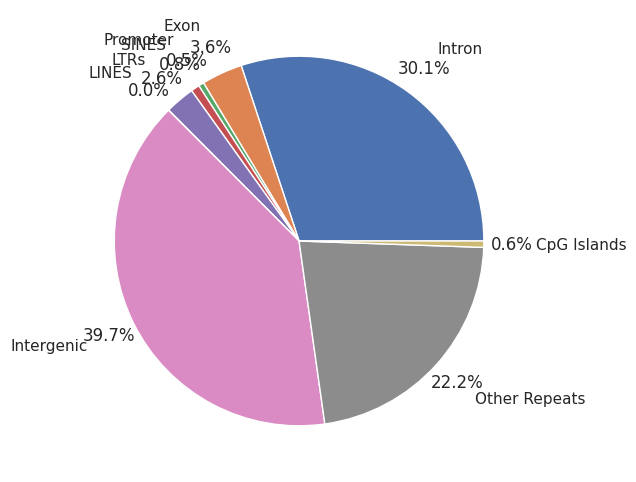

In [332]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df['Number of Peaks'], labels=df['Region'], autopct='%1.1f%%',pctdistance=1.15,labeldistance=1.28)
plt.show()


In [333]:
# import subprocess
# filename= '/data2st1/junyi/output/cCRE/ALL_sampled_peaks.bed'
# command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed /data2st1/junyi/output/cCRE/peaks_unmap.bed"
# print(command_str)
# subprocess.run(command_str, shell=True)

In [334]:
# bed_allpeaks = "/data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed"
# bed_encode = "/data2st1/junyi/output/convert_enhancer.bed"

# merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [335]:
# merged.saveas("/data2st1/junyi/output/cCRE/merged_mm10.bed")
# non_overlapping.saveas("/data2st1/junyi/output/cCRE/non_overlapping_mm10.bed")

In [45]:

# 打开 bigWig 文件
bw_pcon = "/data2st1/junyi/phascon/mm10.60way.phastCons.bw"

In [46]:
def cal_pasconscore(input_bed, input_bw):

    bw = pyBigWig.open(input_bw)
    
    scores_list_non = []

    with open(input_bed, "r") as bed_file:
        for line in bed_file:
            line_s = line.strip().split('\t')
            chrom, start, end= line_s[0], line_s[1], line_s[2]
            start = int(start)
            end = int(end)
            summit = (start +
                    end) // 2
            

            # 获取 PhastCons 分数
            try:
                scores = bw.values(chrom, summit -250, summit + 250)
                scores = [score for score in scores if score is not None]
            except:
                continue    
            # 计算平均分数
            # mean_score = np.mean(scores)
            # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
            scores_list_non.append(scores)

    scores_array_non = np.array(scores_list_non)
    scores_array_non = np.nan_to_num(scores_array_non)
    #mean_value_non = np.mean(scores_array_non, axis=0)

    return scores_array_non

In [338]:
df_dar_wil = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")

In [339]:
df_dar_wil.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed",index=False,header=False, sep="\t")

In [51]:
ovlp_rdhs = "/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed"
scores_array = cal_pasconscore(ovlp_rdhs, bw_pcon)
mean_value = np.mean(scores_array, axis=0)

In [50]:
# 
non_ovlp_rdhs = "/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed"
scores_array_non = cal_pasconscore(non_ovlp_rdhs, bw_pcon)
mean_value_non = np.mean(scores_array_non, axis=0)

In [ ]:
dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
mean_value_dar = np.mean(scores_array_dar, axis=0)

In [48]:
dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
mean_value_dar = np.mean(scores_array_dar, axis=0)

In [49]:
wil_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed"
scores_array_wil = cal_pasconscore(wil_bed, bw_pcon)
mean_value_wil = np.mean(scores_array_wil, axis=0)

In [47]:
memht_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_mementoht.bed"
scores_array_memht = cal_pasconscore(memht_bed, bw_pcon)
mean_value_memht = np.mean(scores_array_memht, axis=0)

In [52]:
sns.set_style("whitegrid")


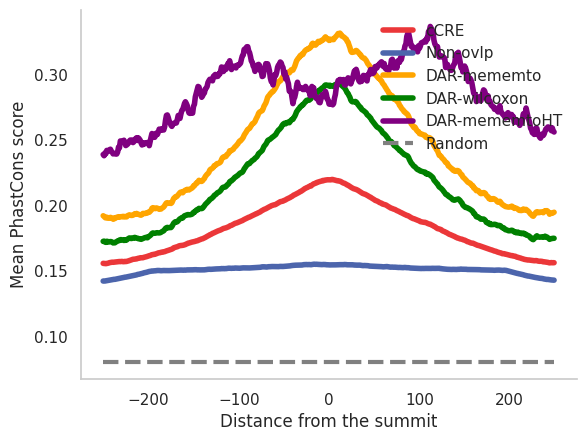

In [53]:
x = np.arange(-250, 250)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.plot(x, mean_value,color='#EB3739', label='cCRE',linewidth=4)
plt.plot(x, mean_value_non, color='#4C65AC', label='Non-ovlp',linewidth=4)
plt.plot(x, mean_value_dar, color='Orange', label='DAR-mememto',linewidth=4)
plt.plot(x, mean_value_wil, color='green', label='DAR-wilcoxon',linewidth=4)
plt.plot(x, mean_value_memht, color='purple', label='DAR-mememtoHT',linewidth=4)
plt.plot(x, np.zeros_like(x)+0.08, color='grey',label='Random', linestyle='--', linewidth=3)
plt.xlabel('Distance from the summit')
plt.ylabel('Mean PhastCons score')
plt.legend(loc='upper right',frameon=False)
plt.grid(visible=False)
plt.axis('tight')
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

plt.show()

